In [156]:
###Calculate APOGEE field mass with PARSEC isochrones
import astropy
from astropy.io import fits, ascii
from astropy.table import Table
import numpy as np
from scipy.interpolate import interp1d

#find duplicates in data
def dups(data):
    '''
    - data: some 1d array-like object that possibly has duplicate values
    Returns dictionary of duplicates and array of indices
    '''
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def apogee_field_mass(age,metallicity,maxabsH,minabsH,selectfunc,number,parsec_path):
    
    """
    This is used to calculate the mass of stars in a field
    - age: age of stars to use to pick out isochrone
    - metallicity: metallicity of stars to use to pick out isochrone
    - maxabsH: max value of H for the field 
    - minabsH: min vale of H for the field
    - selectfunc: selection function for the field
    - number: number of stars observed
    - parsec_path: dat file of PARSEC isochrones
    """
    
    ###Load in isochrones from parsec
    parsecall = ascii.read(parsec_path, format='basic', delimiter='\s')
    rgb = np.where(parsecall['label']==3)
    parsec = parsecall[rgb]
    
    #find closest parsec isochrone z fraction
    age = np.log10(age*(10**9))
    parsec_mets = np.unique(np.asarray((np.log10(parsec['Zini']/0.02))))
    met_index = np.absolute(parsec_mets-metallicity*np.ones(len(parsec_mets))).argmin()
    z_iso = 0.02*(10**parsec_mets[met_index])
    
    #find closest parsec isochrone age
    parsec_ages = np.unique(np.asarray(parsec['logAge']))
    age_index = np.absolute(parsec_ages-age*np.ones(len(parsec_ages))).argmin()
    age_iso = parsec_ages[age_index]
    
    #pick out isochrone, interpolate, and find difference
    single_iso = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso)&(parsec['Hmag']<=maxabsH))

    upto = np.where(parsec[single_iso]['Hmag']==min(parsec[single_iso]['Hmag']))
    new_parsec = parsec[single_iso][0:int(np.squeeze(upto))]
    
    inter_iso = interp1d(new_parsec['Hmag'][::-1],new_parsec['int_IMF'][::-1],kind='linear',bounds_error=False,
                         fill_value='extrapolate',assume_sorted=False) #fill_value=(np.nan,np.nan)
    
    diff_IMF = np.absolute(inter_iso(maxabsH)-inter_iso(minabsH))
    
    return (selectfunc*number)/diff_IMF
    

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat',format='basic', delimiter='\s')
rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

In [4]:
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

In [5]:
def dist2LMC(ra, dec, alph0, delt0, pa, io):
    '''
    - ra: right ascension of stars
    - dec: declination of stars
    - alph0: right ascension of center of LMC
    - delt0: declination of center of LMC
    - pa: position angle of line of nodes
    - io: inclination of LMC disk
    Calculate distance to stars in LMC assuming an inclined disk in the sky
    '''
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

stardist = dist2LMC(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsH = absmag(clndr16['H'],stardist)-clndr16['AK_TARG']
corabsK = absmag(clndr16['K'],stardist)-clndr16['AK_TARG']

NameError: name 'interpolate' is not defined

In [158]:
#Field LMC9

lmc9 = np.where(clndr16['FIELD']=='LMC9')

print(apogee_field_mass(8.7,-0.6,max(corabsH[lmc9]),min(corabsH[lmc9]),clndr16[lmc9]['SELECTFUNC'][0],\
                  len(np.squeeze(lmc9)),'/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat'))




318542818.3535509


In [7]:
single_iso = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso)&(parsec['Hmag']<=maxabsH))
#parsec[single_iso]['Hmag']

NameError: name 'z_iso' is not defined

In [157]:
metallicity = -0.6
age = 9.1
maxabsH = max(corabsH[lmc9])
minabsH = min(corabsH[lmc9])
number = len(clndr16[lmc9])
selectfunc = clndr16[lmc9]['SELECTFUNC'][0]
    
    ###Load in isochrones from parsec
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', format='basic', delimiter='\s')
rgb = np.where(parsecall['label']==3)
parsec = parsecall#[rgb]
    
    #find closest parsec isochrone z fraction
    
parsec_mets = np.unique(np.asarray((np.log10(parsec['Zini']/0.02))))
met_index = np.absolute(parsec_mets-metallicity*np.ones(len(parsec_mets))).argmin()
z_iso = 0.02*(10**parsec_mets[met_index])
    
    #find closest parsec isochrone age
age = np.log10(age*(10**9))
parsec_ages = np.unique(np.asarray(parsec['logAge']))
age_index = np.absolute(parsec_ages-age*np.ones(len(parsec_ages))).argmin()
age_iso = parsec_ages[age_index]
    
    #pick out isochrone, interpolate, and find difference
single_iso = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso)&(parsec['Hmag']<=maxabsH))

upto = np.where(parsec[single_iso]['Hmag']==min(parsec[single_iso]['Hmag']))
new_parsec = parsec[single_iso][0:int(np.squeeze(upto))]
    
inter_iso = interp1d(new_parsec['Hmag'][::-1],new_parsec['int_IMF'][::-1],kind='linear',bounds_error=False,
                         fill_value='extrapolate',assume_sorted=False) #fill_value=(np.nan,np.nan)
    

# def extrap1d(interpolator):
#     xs = interpolator.x
#     ys = interpolator.y

#     def pointwise(x):
#         if x < xs[0]:
#             return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
#         elif x > xs[-1]:
#             return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
#         else:
#             return interpolator(x)

#     def ufunclike(xs):
#         return np.array(map(pointwise, np.array(xs)))

#     return ufunclike
    
# ex = extrap1d(inter_iso)


diff_IMF = np.absolute(inter_iso(maxabsH)-inter_iso(minabsH))
    
print((selectfunc*number)/diff_IMF)

318542818.3535509


In [152]:
list(ex(minabsH))

TypeError: iteration over a 0-d array

In [102]:
a,b = dups(parsec[single_iso]['Hmag'])
print(b)

{-6.027: (array([2, 8]),)}


In [126]:
test = np.where(parsec[single_iso]['Hmag']==min(parsec[single_iso]['Hmag']))
    
range(10)[0:int(np.squeeze(test))]

range(0, 5)

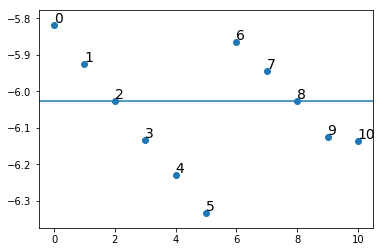

-6.333
-6.333


In [108]:
plt.scatter(range(len(parsec[single_iso]['Hmag'])),parsec[single_iso]['Hmag'])
for j in range(len(parsec[single_iso])):
    plt.text(range(len(parsec[single_iso]['Hmag']))[j]*(1.0-0.001),
             parsec[single_iso]['Hmag'][j]*(1.0-0.001),range(len(parsec[single_iso]))[j],
             fontsize=14)
plt.axhline(-6.027)
plt.show()

print(min(parsec[single_iso]['Hmag']))
print(parsec[single_iso]['Hmag'][5])

In [16]:
import pandas as pd

In [20]:
(Table(parsec[single_iso]).to_pandas()).sort_values(by='Hmag')

,Zini,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,...,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Jmag,Hmag,Ksmag
5,0.004605,9.95,0.963938,2.465041,0.887,3.373,3.5449,0.144,3,0.0,...,0.2723,0.000705,0.000346,0.002036,-1.0,0.004675,-3.663,-5.413,-6.333,-6.604
4,0.004605,9.95,0.963930,2.465039,0.894,3.339,3.5485,0.196,3,0.0,...,0.2723,0.000705,0.000346,0.002036,-1.0,0.004675,-3.577,-5.317,-6.230,-6.494
10,0.004605,9.95,0.967322,2.465808,0.627,3.309,3.5523,0.087,7,0.0,...,0.2684,0.000694,0.000355,0.002030,-1.0,0.005906,-3.503,-5.234,-6.135,-6.402
3,0.004605,9.95,0.963922,2.465037,0.899,3.306,3.5520,0.245,3,0.0,...,0.2723,0.000705,0.000346,0.002036,-1.0,0.004675,-3.495,-5.226,-6.132,-6.389
9,0.004605,9.95,0.967321,2.465808,0.637,3.297,3.5484,0.090,7,0.0,...,0.2684,0.000694,0.000355,0.002030,-1.0,0.005906,-3.473,-5.213,-6.124,-6.396
2,0.004605,9.95,0.963914,2.465035,0.904,3.271,3.5556,0.297,3,0.0,...,0.2723,0.000705,0.000346,0.002036,-1.0,0.004675,-3.408,-5.129,-6.027,-6.279
8,0.004605,9.95,0.967321,2.465808,0.651,3.260,3.5497,0.142,7,0.0,...,0.2684,0.000694,0.000354,0.002030,-1.0,0.005913,-3.381,-5.117,-6.027,-6.294
7,0.004605,9.95,0.967320,2.465808,0.658,3.232,3.5524,0.186,7,0.0,...,0.2684,0.000695,0.000354,0.002030,-1.0,0.005920,-3.310,-5.039,-5.943,-6.204
1,0.004605,9.95,0.963906,2.465033,0.908,3.237,3.5591,0.348,3,0.0,...,0.2723,0.000705,0.000346,0.002036,-1.0,0.004675,-3.322,-5.033,-5.924,-6.169
6,0.004605,9.95,0.967320,2.465808,0.662,3.206,3.5552,0.225,7,0.0,...,0.2684,0.000695,0.000354,0.002030,-1.0,0.005929,-3.245,-4.968,-5.865,-6.121


In [44]:
ordered = (Table(parsec[single_iso]).to_pandas()).sort_values(by='Hmag')

points = zip(parsec[single_iso]['Hmag'],parsec[single_iso]['int_IMF'])
points = sorted(points, key=lambda point: point[0])
x1, y1 = zip(*points)

inter_iso = interp1d(x1,y1,kind='slinear',bounds_error=True,fill_value=(np.nan,np.nan),assume_sorted=False)

In [43]:
from scipy.interpolate import CubicSpline
# CubicSpline(x1,y1)
print(x1)
print(y1)

(-6.333, -6.23, -6.135, -6.132, -6.124, -6.027, -6.027, -5.943, -5.924, -5.865, -5.819)
(2.4650406837, 2.4650387764, 2.4658083916, 2.4650371075, 2.4658083916, 2.4650352001, 2.4658081532, 2.4658081532, 2.4650332928, 2.4658081532, 2.4650313854)


In [53]:
len(parsecall)

148402

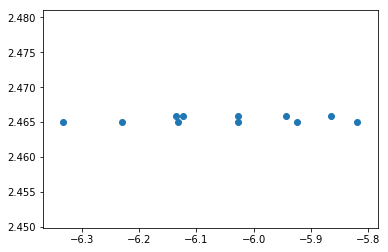

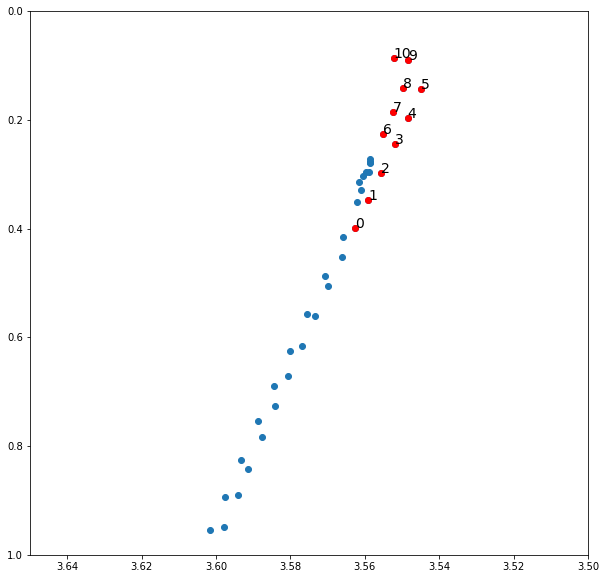

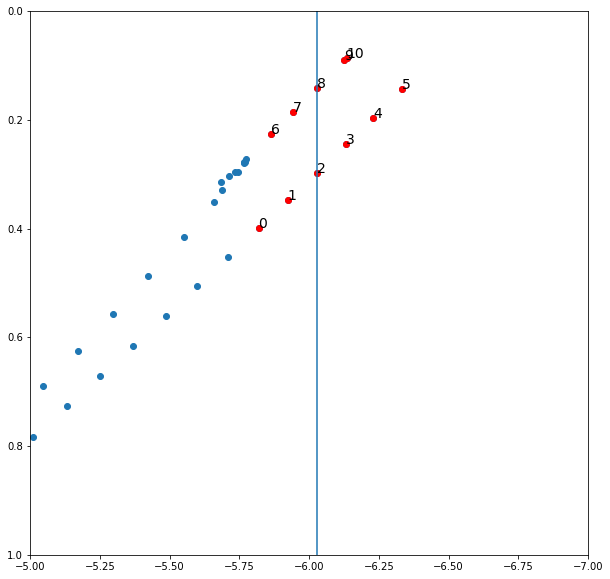

In [114]:
plt.scatter(x1,y1)
plt.show()

whole = np.where((parsecall['logAge'] == age_iso)&(parsecall['Zini'] == z_iso))

plt.figure(figsize=[10,10])
plt.scatter(parsecall[whole]['logTe'],parsecall[whole]['logg'])
plt.scatter(parsec[single_iso]['logTe'],parsec[single_iso]['logg'],c='r')
for j in range(len(parsec[single_iso])):
    plt.text(parsec[single_iso]['logTe'][j]*(1.0),
             parsec[single_iso]['logg'][j]*(1.0),range(len(parsec[single_iso]))[j],
             fontsize=14)
plt.xlim(3.5,3.65)
plt.ylim(0,1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

# plt.scatter(parsecall[whole]['logTe'],parsecall[whole]['logg'])
plt.figure(figsize=[10,10])
plt.scatter(parsecall[whole]['Hmag'],parsecall[whole]['logg'])
plt.scatter(parsec[single_iso]['Hmag'],parsec[single_iso]['logg'],c='r')
for j in range(len(parsec[single_iso])):
    plt.text(parsec[single_iso]['Hmag'][j]*(1.0),
             parsec[single_iso]['logg'][j]*(1.0),range(len(parsec[single_iso]))[j],
             fontsize=14)
plt.xlim(-7,-5)
plt.ylim(0,1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axvline(-6.027)
plt.show()

In [85]:
np.sort(np.asarray(parsec[single_iso]['Hmag']))
print(x1)
print(y1)

(-6.333, -6.23, -6.135, -6.132, -6.124, -6.027, -6.027, -5.943, -5.924, -5.865, -5.819)
(2.4650406837, 2.4650387764, 2.4658083916, 2.4650371075, 2.4658083916, 2.4650352001, 2.4658081532, 2.4658081532, 2.4650332928, 2.4658081532, 2.4650313854)


In [ ]:
test1 = np.where(parsec['Zini']==z_iso)
test2 = np.where(parsec['logAge']==age_iso)
test3 = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso))
test4 = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso)&(parsec['label']==3))

In [ ]:
print(len(np.squeeze(test1)))
print(len(np.squeeze(test2)))
print(len(np.squeeze(test3)))

In [ ]:
plt.figure(figsize=[12,10])
plt.scatter(np.log10(parsec['Zini'][test3]/0.02),parsec['logAge'][test3],c='k',cmap='jet')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
# plt.savefig('PARSECgrid.pdf',bbox_inches='tight')
plt.show()

In [ ]:
plt.hist(parsec['Hmag'][test3])
plt.show()

reds = np.where(parsec['label']==3)
plt.hist(parsec['Hmag'][reds])
plt.show()

plt.hist(parsec['Hmag'][test4])
plt.show()

In [ ]:
plt.hist(corabsH)

In [ ]:
parsec.columns

In [ ]:
metallicity = -0.89
age = 10.1
maxabsH = max(corabsH[lmc9])
    
###Load in isochrones from parsec
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', format='basic',
                       delimiter='\s')
rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]
    
#find closest parsec isochrone z fraction
age = np.log10(age*(10**9))
parsec_mets = np.unique(np.asarray((np.log10(parsec['Zini']/0.02))))
met_index = np.absolute(parsec_mets-metallicity*np.ones(len(parsec_mets))).argmin()
z_iso = 0.02*(10**parsec_mets[met_index])
    
#find closest parsec isochrone age
parsec_ages = np.unique(np.asarray(parsec['logAge']))
age_index = np.absolute(parsec_ages-age*np.ones(len(parsec_ages))).argmin()
age_iso = parsec_ages[age_index]
    
#pick out isochrone
test4 = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso)&(parsec['label']==3))

plt.hist(parsec['logTe'][test4],density=True,label='PARSEC')
plt.hist(np.log10(clndr16['TEFF']),density=True,label='APOGEE',alpha=0.75)
plt.legend()
plt.title(r'$Log(T_{eff})$')
plt.xlabel(r'$Log(T_{eff})$')
plt.show()

plt.hist(parsec['Hmag'][test4],density=True,label='PARSEC')
plt.hist(corabsH,density=True,label='APOGEE',alpha=0.75)
plt.legend()
plt.title(r'H Magnitude')
plt.xlabel(r'H')
plt.show()

plt.hist(parsec['Ksmag'][test4],density=True,label='PARSEC')
plt.hist(corabsK,density=True,label='APOGEE',alpha=0.75)
plt.legend()
plt.title(r'K Magnitude')
plt.xlabel(r'K')
plt.show()

plt.hist(np.log10(parsec['Zini'][test4]/0.02),density=True,label='PARSEC')
plt.hist(clndr16['FE_H'],density=True,label='APOGEE',alpha=0.75)
plt.legend()
plt.title(r'Metallicity')
plt.xlabel(r'[Fe/H]')
plt.show()

plt.hist(parsec['logg'][test4],density=True,label='PARSEC')
plt.hist(clndr16['LOGG'],density=True,label='APOGEE',alpha=0.75)
plt.legend()
plt.title(r'Log(g)')
plt.xlabel(r'Log(g)')
plt.show()

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(clndr16['J']-clndr16['K'],clndr16['J']-clndr16['H'],c=clndr16['AK_TARG'],cmap='nipy_spectral',
            alpha=0.5)